# PINNs for the 1D Heat Equation (JAX)
This notebook trains two Physics-Informed Neural Networks (PINNs) with JAX, Equinox, and Optax to solve the 1D heat equation with homogeneous Dirichlet boundary conditions. We mirror the PyTorch workflow with soft- and hard-constraint formulations.

## Problem setup
We solve the dimensionless heat equation
$$ u_t = \alpha u_{xx}, \quad x \in [0, 1], \; t \in [0, 1] $$
with Dirichlet boundaries $u(0, t) = u(1, t) = 0$ and initial condition $u(x, 0) = \sin(\pi x)$. The analytic solution is $u(x, t) = e^{-\alpha \pi^2 t} \sin(\pi x)$, which we use for supervision at $t=0$ and for qualitative evaluation.

In [1]:
import math
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pandas as pd

USE_64 = False  # float64 is slower on most accelerators; toggle if you need extra precision.
jax.config.update("jax_enable_x64", USE_64)

key = jrandom.PRNGKey(42)
print(f"JAX devices: {jax.devices()}")


JAX devices: [CpuDevice(id=0)]


In [2]:
ALPHA = 0.1
X_MIN, X_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

def initial_condition(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.sin(jnp.pi * x)

def exact_solution(x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    return jnp.exp(-ALPHA * (math.pi ** 2) * t) * jnp.sin(math.pi * x)

def sample_interior(key: jax.Array, n: int):
    key_x, key_t = jrandom.split(key)
    x = jrandom.uniform(key_x, (n,), minval=X_MIN, maxval=X_MAX)
    t = jrandom.uniform(key_t, (n,), minval=T_MIN, maxval=T_MAX)
    return x, t

def sample_initial(key: jax.Array, n: int):
    x = jrandom.uniform(key, (n,), minval=X_MIN, maxval=X_MAX)
    t = jnp.zeros_like(x) + T_MIN
    return x, t

def sample_boundary(key: jax.Array, n: int):
    key_left, key_right = jrandom.split(key)
    t_left = jrandom.uniform(key_left, (n,), minval=T_MIN, maxval=T_MAX)
    t_right = jrandom.uniform(key_right, (n,), minval=T_MIN, maxval=T_MAX)
    x_left = jnp.zeros_like(t_left) + X_MIN
    x_right = jnp.zeros_like(t_right) + X_MAX
    return (x_left, t_left), (x_right, t_right)

In [3]:
class HeatPINN(eqx.Module):
    mlp: eqx.nn.MLP
    hard_boundary: bool = eqx.field(static=True)

    def __call__(self, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
        inputs = jnp.stack([x, t], axis=-1)
        out = self.mlp(inputs)
        if self.hard_boundary:
            xi = (x - X_MIN) / (X_MAX - X_MIN)
            out = xi * (1.0 - xi) * out
        return jnp.squeeze(out, axis=-1)

def make_model(key, *, hidden_layers: int = 4, hidden_width: int = 64, hard_boundary: bool = False) -> HeatPINN:
    mlp = eqx.nn.MLP(
        in_size=2,
        out_size=1,
        width_size=hidden_width,
        depth=hidden_layers,
        activation=jnp.tanh,
        key=key,
    )
    return HeatPINN(mlp=mlp, hard_boundary=hard_boundary)

def pde_residual(model: HeatPINN, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    u = lambda x0, t0: model(x0, t0)
    u_t = jax.grad(u, argnums=1)(x, t)
    u_x = jax.grad(u, argnums=0)(x, t)
    u_xx = jax.grad(lambda x0, t0: jax.grad(u, argnums=0)(x0, t0), argnums=0)(x, t)
    return u_t - ALPHA * u_xx

In [4]:
def train_pinn(*, steps: int = 2500, lr: float = 1e-3, interior_samples: int = 1024, boundary_samples: int = 256, initial_samples: int = 256, hard_boundary: bool = False, seed: int = 42):
    key = jrandom.PRNGKey(seed)
    model_key, key = jrandom.split(key)
    model = make_model(model_key, hard_boundary=hard_boundary)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    history = []

    def loss_fn(model: HeatPINN, key: jax.Array):
        key, int_key, init_key, bc_key = jrandom.split(key, 4)

        x_i, t_i = sample_interior(int_key, interior_samples)

        residual = jax.vmap(pde_residual, in_axes=(None, 0, 0))(model, x_i, t_i)
        loss_residual = jnp.mean(residual ** 2)

        x_init, t_init = sample_initial(init_key, initial_samples)
        u_init = jax.vmap(lambda x, t: model(x, t))(x_init, t_init)
        target_init = exact_solution(x_init, t_init)
        loss_initial = jnp.mean((u_init - target_init) ** 2)

        loss_boundary = jnp.array(0.0)
        if not model.hard_boundary:
            (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(bc_key, boundary_samples)
            u_b0 = jax.vmap(lambda x, t: model(x, t))(x_b0, t_b0)
            u_b1 = jax.vmap(lambda x, t: model(x, t))(x_b1, t_b1)
            loss_boundary = jnp.mean(u_b0 ** 2) + jnp.mean(u_b1 ** 2)

        total = loss_residual + loss_initial + loss_boundary
        return total, (loss_residual, loss_initial, loss_boundary)

    # JIT-compile the loss/grad and the optimizer step to remove Python overhead in the loop.
    loss_and_grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)
    loss_and_grads = eqx.filter_jit(loss_and_grads)

    @eqx.filter_jit
    def train_step(model, opt_state, key):
        (loss_value, (lres, linit, lbc)), grads = loss_and_grads(model, key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value, lres, linit, lbc

    for step in range(1, steps + 1):
        key, step_key = jrandom.split(key)
        model, opt_state, loss_value, lres, linit, lbc = train_step(model, opt_state, step_key)

        history.append({
            "step": step,
            "loss": float(loss_value),
            "residual": float(lres),
            "initial": float(linit),
            "boundary": float(lbc),
        })

        if step % 500 == 0 or step == 1:
            tag = "hard" if hard_boundary else "soft"
            msg = f"[{tag}] step {step:4d} | total={loss_value:.3e} | residual={lres:.3e} | init={linit:.3e}"
            if not hard_boundary:
                msg += f" | bc={lbc:.3e}"
            print(msg)

    return model, history



## Soft-constraint PINN
Boundary conditions are enforced by adding their residuals to the loss (classical soft-constraint PINN).

In [5]:
soft_model, soft_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=False,
    seed=123,
)

[soft] step    1 | total=5.236e-01 | residual=2.289e-04 | init=5.211e-01 | bc=2.314e-03
[soft] step  500 | total=5.122e-04 | residual=4.003e-04 | init=4.283e-05 | bc=6.912e-05
[soft] step 1000 | total=4.229e-04 | residual=9.547e-05 | init=1.175e-04 | bc=2.099e-04
[soft] step 1500 | total=8.465e-05 | residual=7.862e-05 | init=3.430e-06 | bc=2.604e-06
[soft] step 2000 | total=8.885e-05 | residual=8.246e-05 | init=2.040e-06 | bc=4.346e-06
[soft] step 2500 | total=7.071e-05 | residual=6.027e-05 | init=6.608e-06 | bc=3.829e-06


## Hard-constraint PINN
The network output is wrapped in $x (1 - x)$ so that $u(0, t) = u(1, t) = 0$ is satisfied exactly. No boundary penalty terms are needed.

In [6]:
hard_model, hard_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=True,
    seed=456,
)

[hard] step    1 | total=4.783e-01 | residual=1.646e-04 | init=4.781e-01
[hard] step  500 | total=3.473e-05 | residual=3.177e-05 | init=2.963e-06
[hard] step 1000 | total=7.696e-06 | residual=6.494e-06 | init=1.201e-06
[hard] step 1500 | total=4.206e-06 | residual=3.235e-06 | init=9.711e-07
[hard] step 2000 | total=3.645e-06 | residual=2.715e-06 | init=9.296e-07
[hard] step 2500 | total=4.925e-05 | residual=3.934e-05 | init=9.905e-06


In [7]:
def evaluate_model(model: HeatPINN, num_x: int = 100, num_t: int = 50):
    x = jnp.linspace(X_MIN, X_MAX, num_x)
    t = jnp.linspace(T_MIN, T_MAX, num_t)
    X, T = jnp.meshgrid(x, t, indexing="ij")
    xt_pairs = jnp.stack([X.ravel(), T.ravel()], axis=1)
    preds = jax.vmap(lambda xt: model(xt[0], xt[1]))(xt_pairs)
    U = preds.reshape((num_x, num_t))
    U_exact = exact_solution(X, T)
    error = jnp.abs(U - U_exact)
    return X, T, U, U_exact, error

soft_eval = evaluate_model(soft_model)
hard_eval = evaluate_model(hard_model)

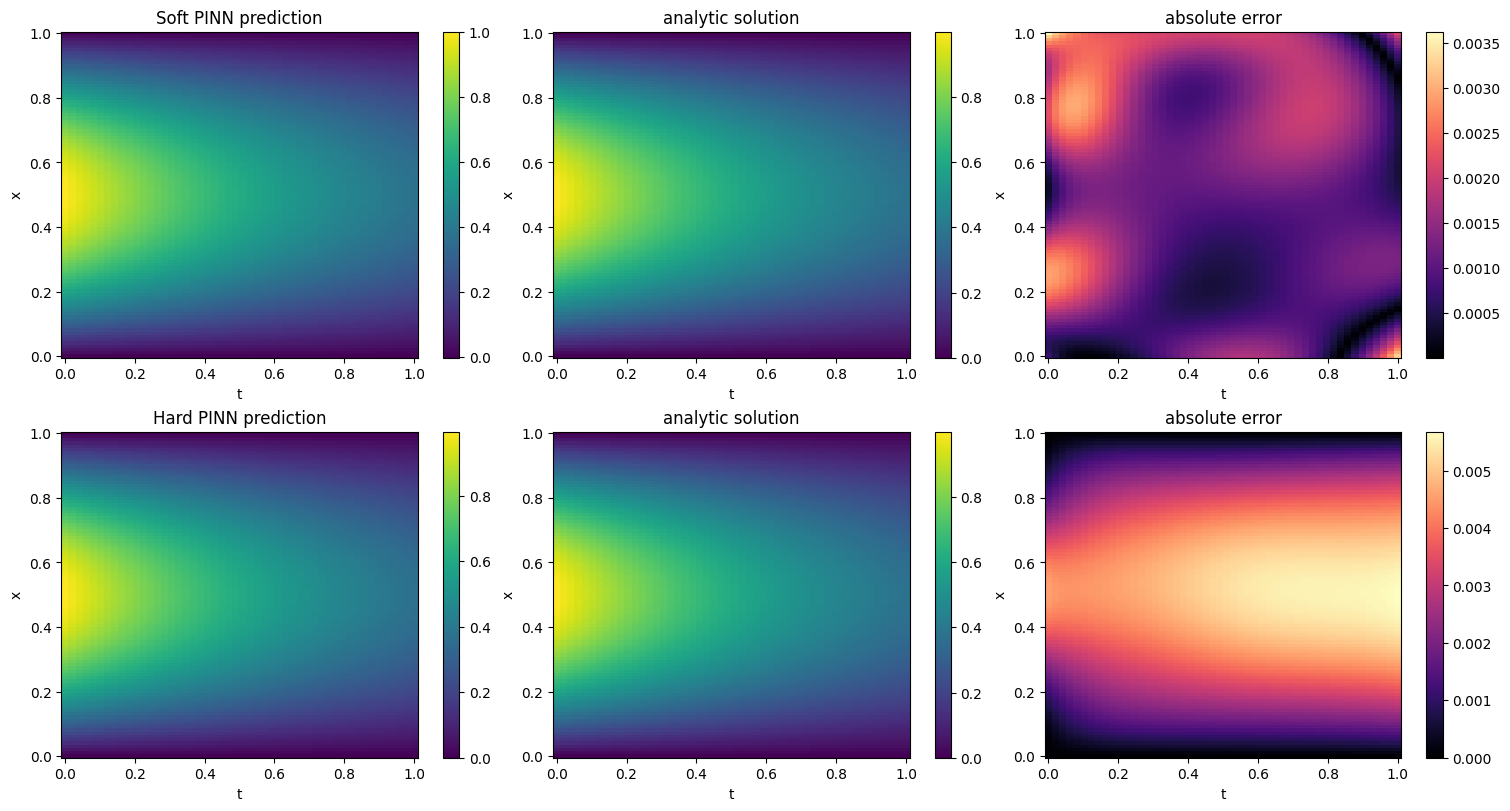

In [8]:
def plot_heatmaps(X, T, prediction, truth, error, title_prefix, axes_row):
    im0 = axes_row[0].pcolormesh(T, X, prediction, shading="auto", cmap="viridis")
    axes_row[0].set_title(f"{title_prefix} prediction")
    axes_row[0].set_xlabel("t")
    axes_row[0].set_ylabel("x")
    plt.colorbar(im0, ax=axes_row[0])

    im1 = axes_row[1].pcolormesh(T, X, truth, shading="auto", cmap="viridis")
    axes_row[1].set_title("analytic solution")
    axes_row[1].set_xlabel("t")
    axes_row[1].set_ylabel("x")
    plt.colorbar(im1, ax=axes_row[1])

    im2 = axes_row[2].pcolormesh(T, X, error, shading="auto", cmap="magma")
    axes_row[2].set_title("absolute error")
    axes_row[2].set_xlabel("t")
    axes_row[2].set_ylabel("x")
    plt.colorbar(im2, ax=axes_row[2])

Xs, Ts, soft_pred, soft_true, soft_err = soft_eval
Xh, Th, hard_pred, hard_true, hard_err = hard_eval

fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
plot_heatmaps(Xs, Ts, soft_pred, soft_true, soft_err, "Soft PINN", axes[0])
plot_heatmaps(Xh, Th, hard_pred, hard_true, hard_err, "Hard PINN", axes[1])
plt.show()

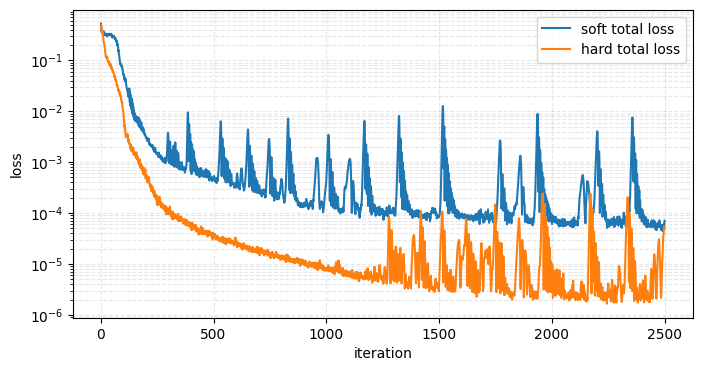

In [9]:
def history_to_frame(history, label):
    frame = pd.DataFrame(history)
    frame["label"] = label
    return frame

soft_df = history_to_frame(soft_history, "soft")
hard_df = history_to_frame(hard_history, "hard")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(soft_df["step"], soft_df["loss"], label="soft total loss")
ax.plot(hard_df["step"], hard_df["loss"], label="hard total loss")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.legend()
ax.grid(True, which="both", ls="--", alpha=0.3)
plt.show()